In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from keras.models import Sequential
from keras.layers import Dense
import random

Using TensorFlow backend.


# Data

## Origination

In [2]:
dates_ = pd.date_range('01-01-2011','01-01-2012',freq='D')

In [3]:
df_test = pd.DataFrame({'date':dates_, 'values' : np.zeros(len(dates_))})

In [4]:
for i, values in df_test.iterrows():
    if i % 5 == 0:
        df_test.loc[i,'values'] = 7 + random.randint(-1,3)
    else:
        df_test.loc[i,'values'] = 0

In [5]:
split_date = '10-01-2011'
df_train = df_test.loc[df_test['date'] <= split_date].copy()
df_test = df_test.loc[df_test['date'] > split_date].copy()

## Transformation to process into algorithms

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(df, look_back=1, column_target ='values', column_lag_name='_lag_', default_na=0):
    columns_x = []
    for i in range(1,look_back+1):
        df[column_target+column_lag_name+str(i)] = df['values'].shift(i)
        df[column_target+column_lag_name+str(i)] = df[column_target+column_lag_name+str(i)].fillna(default_na)
        columns_x.append(column_target+column_lag_name+str(i))
    return df[columns_x].values, df[column_target].values
# reshape into X=t and Y=t+1

In [7]:
look_back = 3
X_train, y_train = create_dataset(df=df_train, look_back=look_back, column_target ='values', column_lag_name='_lag_', default_na=0)
X_test, y_test = create_dataset(df=df_test, look_back=look_back, column_target ='values', column_lag_name='_lag_', default_na=0)

# Prediction Development

## XGBoost

In [8]:
reg = xgb.XGBRegressor(
    n_estimators=5000,
    max_depth=30,
    learning_rate=0.01,
    booster='dart',
    n_jobs=4
    )

In [9]:
reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=1000,
        verbose=False) # Change verbose to True if you want to see it train

[23:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

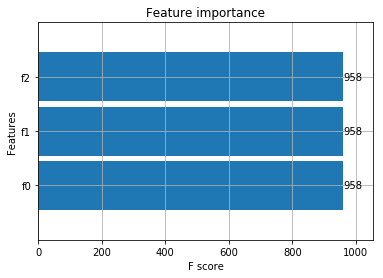

In [10]:
_ = plot_importance(reg, height=0.9)

In [11]:
df_test['values_prediction'] = reg.predict(X_test)
xgboost_result = pd.concat([df_test, df_train], sort=False).sort_values('date')

## Neural Network

In [12]:
np.random.seed(7)

In [13]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Fit the model
model.fit(X_train, y_train, epochs=5000, batch_size=10, verbose=0)

In [15]:
predicted_values = model.predict(X_test, batch_size=50, verbose=False)

In [16]:
nn_result = pd.DataFrame({'date' : df_test['date'] , 'value' : y_test, 'predicted' : predicted_values.reshape(1,-1)[0]})

# Results

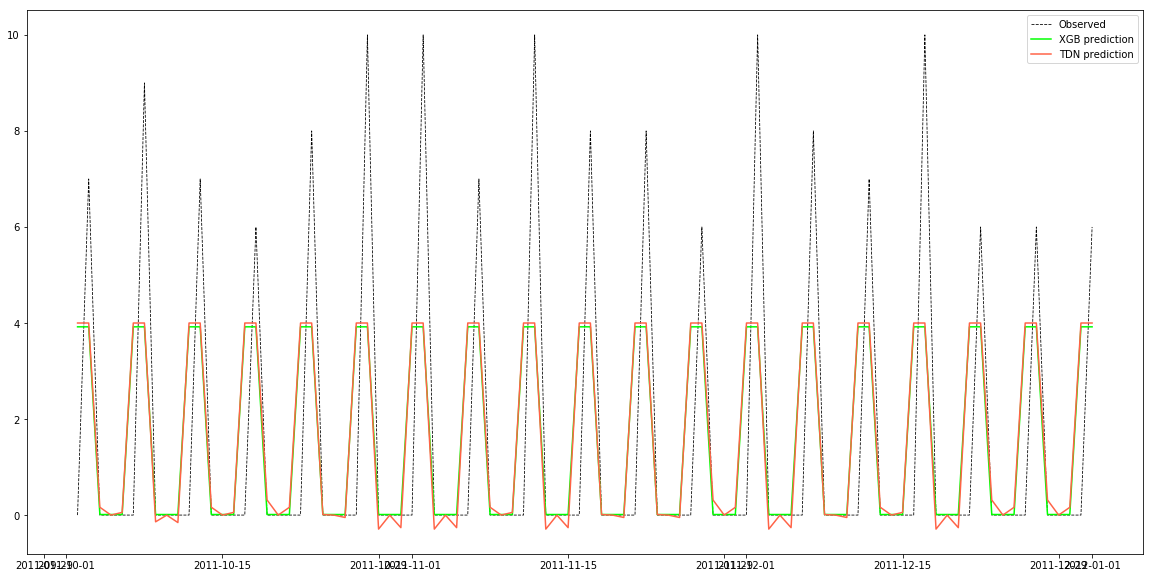

In [18]:
plt.figure(figsize=(20,10))

#Original
plt.plot(
    xgboost_result[min(df_test.index):]['date'],
    xgboost_result[min(df_test.index):]['values'],
    label='Observed',
    c='black',
    linestyle='dashed',
    linewidth=0.8
)

# XGBoost Prediction
plt.plot(
    xgboost_result[min(df_test.index):]['date'],
    xgboost_result[min(df_test.index):]['values_prediction'],
    label='XGB prediction',
    c='lime')

# TDD Neural Network Prediction
plt.plot(
    nn_result['date'],
    nn_result['predicted'],
    label='TDN prediction',
    c='tomato')

plt.legend()

plt.show()